In [9]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../..')

# Graph imports
from src.logit_graph.graph import GraphModel 
import src.logit_graph.utils as utils
import src.logit_graph.graph as graph
import src.logit_graph.logit_estimator as estimator

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from scipy import stats
import pickle

from IPython.display import display
from pyvis.network import Network

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
datasets = f'../../data/connectomes/'
connectomes = sorted(os.listdir(datasets)) 
len(connectomes)


19

In [37]:
# Parameters
n = 500 
sigma_values = [-1, -2, -3, -4, -5, -6, -7]
#d_values = [0, 1, 2]
d_values = [1]
n_graphs = 10  # number of graphs to generate for each parameter combination
n_iterations = 100
warm_up = 90 
results = []

for sigma in sigma_values:
    for d in d_values:
        for i in range(n_graphs):
            # Generate graph
            graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
            graphs, _ = graph_model.populate_edges_baseline(warm_up=warm_up, max_iterations=n_iterations, patience=10)
            g = graphs[-1]

            # Perform estimation
            est = estimator.LogitRegEstimator(g, d=d)
            features, labels = est.get_features_labels()
            result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)

            # Store results
            results.append({
                'true_sigma': sigma,
                'true_d': d,
                'estimated_sigma': params[0],
                'estimated_d': d,  # We're using the true d for estimation
                'aic': result.aic,
                'bic': result.bic,
                'llf': result.llf
            })


iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [38]:
import os
os.makedirs('runs/anova_sigma', exist_ok=True)
with open(f'runs/anova_sigma/results_anova.pkl', 'wb') as f:
    pickle.dump(results, f)


In [39]:
with open(f'runs/anova_sigma/results_anova.pkl', 'rb') as f:
    results = pickle.load(f)


In [40]:
# Convert results to DataFrame
df = pd.DataFrame(results)
df.head()

,true_sigma,true_d,estimated_sigma,estimated_d,aic,bic,llf
0,-1,1,-5.032453,1,49397.689773,49426.891974,-24695.844886
1,-1,1,-4.968885,1,50110.891739,50140.093940,-25052.445869
2,-1,1,-4.967182,1,50270.123674,50299.325875,-25132.061837
3,-1,1,-5.031131,1,48971.943213,49001.145414,-24482.971606
4,-1,1,-5.059342,1,49859.120210,49888.322411,-24926.560105


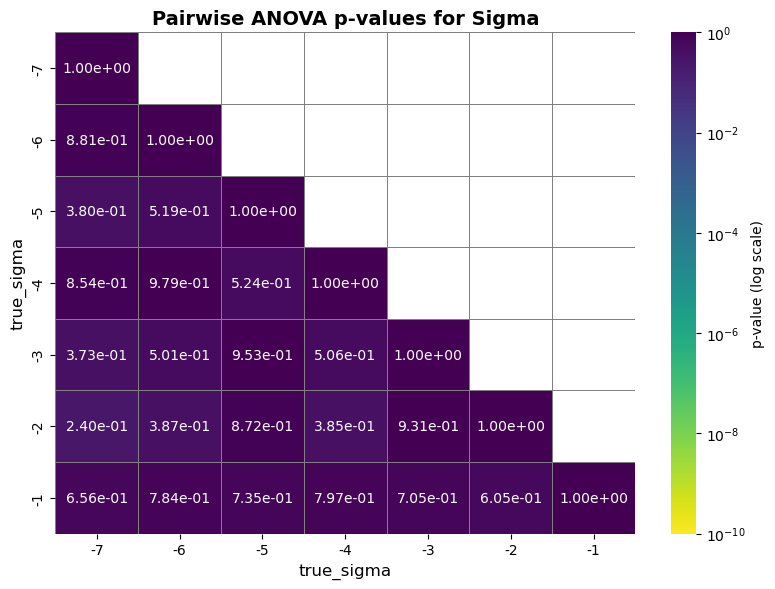

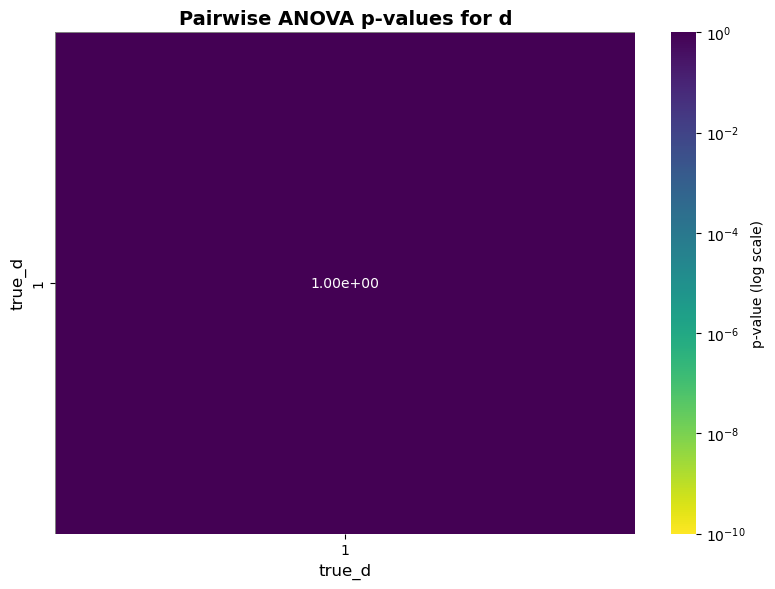

In [43]:
# Create heatmap visualization for ANOVA results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy import stats
from matplotlib.colors import LogNorm

def create_pairwise_anova_heatmap(df, grouping_var, target_var, title):
    """Create a triangular heatmap of pairwise ANOVA p-values with log scale"""
    groups = df.groupby(grouping_var)
    group_keys = sorted(groups.groups.keys())
    n_groups = len(group_keys)
    
    # Initialize matrix for p-values
    p_matrix = np.ones((n_groups, n_groups))
    
    # Compute pairwise ANOVA
    for i, group1_key in enumerate(group_keys):
        for j, group2_key in enumerate(group_keys):
            group1 = groups.get_group(group1_key)[target_var]
            group2 = groups.get_group(group2_key)[target_var]
            f_stat, p_value = stats.f_oneway(group1, group2)
            p_matrix[i, j] = p_value
    
    # Create mask for upper triangle (excluding diagonal)
    mask = np.triu(np.ones_like(p_matrix, dtype=bool), k=1)
    
    # Create heatmap with publication-ready settings
    plt.figure(figsize=(8, 6))
    
    # Use log scale for color mapping with improved gradient
    # viridis_r provides better perceptual uniformity and contrast
    sns.heatmap(p_matrix, 
                annot=True, 
                fmt='.2e',
                cmap='viridis_r',  # Better perceptual gradient
                xticklabels=group_keys,
                yticklabels=group_keys,
                cbar_kws={'label': 'p-value (log scale)'},
                norm=LogNorm(vmin=1e-10, vmax=1),
                linewidths=0.5,
                linecolor='gray',
                mask=mask)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(grouping_var, fontsize=12)
    plt.ylabel(grouping_var, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    return plt.gcf()

# Create heatmaps
fig1 = create_pairwise_anova_heatmap(df, 'true_sigma', 'estimated_sigma', 
                                      'Pairwise ANOVA p-values for Sigma')
plt.savefig('runs/anova_sigma/sigma_anova_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

fig2 = create_pairwise_anova_heatmap(df, 'true_d', 'estimated_sigma', 
                                      'Pairwise ANOVA p-values for d')
plt.savefig('runs/anova_sigma/d_anova_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [44]:
# Perform pairwise ANOVA tests for sigma and d
from itertools import combinations
from scipy import stats
import pandas as pd

def pairwise_anova(df, grouping_var, target_var):
    groups = df.groupby(grouping_var)
    pairs = list(combinations(groups.groups.keys(), 2))
    results = []
    
    for pair in pairs:
        group1 = groups.get_group(pair[0])[target_var]
        group2 = groups.get_group(pair[1])[target_var]
        f_stat, p_value = stats.f_oneway(group1, group2)
        results.append({
            'Comparison': f"{pair[0]} vs {pair[1]}",
            'F-statistic': f"{f_stat:.4f}",
            'p-value': f"{p_value:.2e}"  # Changed to scientific notation
        })
    
    return pd.DataFrame(results)

# Pairwise ANOVA for sigma
sigma_results = pairwise_anova(df, 'true_sigma', 'estimated_sigma')
sigma_table = sigma_results.to_latex(index=False, caption="Pairwise ANOVA tests for sigma", label="tab:sigma_anova")

# Pairwise ANOVA for d
d_results = pairwise_anova(df, 'true_d', 'estimated_sigma')
d_table = d_results.to_latex(index=False, caption="Pairwise ANOVA tests for d", label="tab:d_anova")

print("LaTeX table for sigma ANOVA results:")
print(sigma_table)
print("\nLaTeX table for d ANOVA results:")
print(d_table)

LaTeX table for sigma ANOVA results:
\begin{table}
\caption{Pairwise ANOVA tests for sigma}
\label{tab:sigma_anova}
\begin{tabular}{lll}
\toprule
Comparison & F-statistic & p-value \\
\midrule
-7 vs -6 & 0.0229 & 8.81e-01 \\
-7 vs -5 & 0.8098 & 3.80e-01 \\
-7 vs -4 & 0.0347 & 8.54e-01 \\
-7 vs -3 & 0.8352 & 3.73e-01 \\
-7 vs -2 & 1.4746 & 2.40e-01 \\
-7 vs -1 & 0.2051 & 6.56e-01 \\
-6 vs -5 & 0.4330 & 5.19e-01 \\
-6 vs -4 & 0.0007 & 9.79e-01 \\
-6 vs -3 & 0.4708 & 5.01e-01 \\
-6 vs -2 & 0.7866 & 3.87e-01 \\
-6 vs -1 & 0.0778 & 7.84e-01 \\
-5 vs -4 & 0.4231 & 5.24e-01 \\
-5 vs -3 & 0.0035 & 9.53e-01 \\
-5 vs -2 & 0.0267 & 8.72e-01 \\
-5 vs -1 & 0.1180 & 7.35e-01 \\
-4 vs -3 & 0.4609 & 5.06e-01 \\
-4 vs -2 & 0.7914 & 3.85e-01 \\
-4 vs -1 & 0.0679 & 7.97e-01 \\
-3 vs -2 & 0.0078 & 9.31e-01 \\
-3 vs -1 & 0.1479 & 7.05e-01 \\
-2 vs -1 & 0.2771 & 6.05e-01 \\
\bottomrule
\end{tabular}
\end{table}


LaTeX table for d ANOVA results:
\begin{table}
\caption{Pairwise ANOVA tests for d}
\label{tab:

In [36]:
'finish'

'finish'